# NOTE :

In the queries used in the load_dataset function, each query is fed through GPT which is then used to create a list of ICD codes

In [5]:
import ast
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  

In [6]:
def load_dataset() -> dict:
    train_data_path = '../../../datasets/dataset_training/triplet_dataset_v45_240_queries_10positives_50hn_train.csv'
    eval_data_path = '../../../datasets/dataset_training/triplet_dataset_v45_240_queries_10positives_50hn_eval.csv'
    test_data_path = '../../../datasets/dataset_training/triplet_dataset_v45_240_queries_10positives_50hn_test.csv'
    
    train_df = pd.read_csv(train_data_path)
    eval_df = pd.read_csv(eval_data_path)
    test_df = pd.read_csv(test_data_path)
    dataset = pd.concat([train_df, eval_df, test_df])
    dataset = dataset.iloc[:,1:]

    query_codes_dataset = dict(dataset.groupby(['anchor'])['positives'].apply(set).apply(list))

    return query_codes_dataset

In [7]:
query_codes_dataset = load_dataset()

In [8]:
def load_icd_dataset() -> tuple:
    def select_description(df):
    
        max_length_indices = df.groupby('codes')['length'].idxmax()

        return df.loc[max_length_indices].reset_index(drop = True)


    icd_dataset = pd.read_csv('../../../shekhar_tanwar/ICD-ICD-Triplet/dataset/icd10.csv').iloc[:,14:16]
    icd_dataset.columns = ['codes','description']
    icd_dataset = icd_dataset.drop_duplicates()

    icd_dataset['description'] = icd_dataset['description'].apply(lambda x : x.strip())
    icd_dataset['length'] = icd_dataset['description'].apply(lambda x : len(x))

    icd_dataset_filtered = select_description(icd_dataset)

    icd_reference_lookup = {}
    for row in icd_dataset.itertuples():
        icd_reference_lookup[row.codes.strip()] = row.description.strip()

    description_code_lookup = {}
    for code, code_descriptions in icd_reference_lookup.items():
        code_descriptions = code_descriptions.lower()
        description_code_lookup[code_descriptions] = code

    return icd_reference_lookup, description_code_lookup

In [9]:
icd_reference_lookup, description_code_lookup = load_icd_dataset()

In [10]:
def formatting_dataset(query_codes_dataset, description_code_lookup) -> pd.DataFrame:

    all_queries = list(query_codes_dataset.keys())

    total_codes_list = []
    all_codes = []
    for query in all_queries:
        code_descriptions = query_codes_dataset.get(query, [])
        code_descriptions = [description.lower() for description in code_descriptions]
    
        codes = [description_code_lookup.get(description) for description in code_descriptions]
        all_codes.append(codes)
        total_codes = len(codes)
        total_codes_list.append(total_codes)

    query_codes_analysis = pd.DataFrame(zip(all_queries, all_codes, total_codes_list), columns = ['Queries','Grouped_Codes','Total_Codes'] )
    return query_codes_analysis


In [11]:
query_codes_analysis = formatting_dataset(query_codes_dataset, description_code_lookup)

# Plotting Historgram Of Total Codes by Query Frequency Count

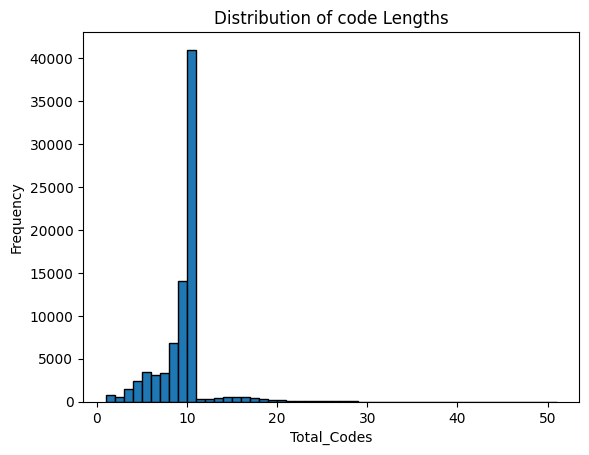

In [12]:
plt.hist(query_codes_analysis['Total_Codes'], bins=range(1, query_codes_analysis['Total_Codes'].max() + 2), edgecolor='black')  
plt.xlabel('Total_Codes')  
plt.ylabel('Frequency')  
plt.title('Distribution of code Lengths')  
plt.show()  

In [13]:

stats = query_codes_analysis['Total_Codes'].describe()  
print(stats)
print("============================")
value_counts = query_codes_analysis['Total_Codes'].value_counts()  
print(value_counts)  

count    80756.000000
mean         9.026908
std          2.681732
min          1.000000
25%          8.000000
50%         10.000000
75%         10.000000
max         50.000000
Name: Total_Codes, dtype: float64
10    40969
9     13989
8      6802
5      3403
7      3381
6      3071
4      2369
3      1468
1       769
16      568
15      536
2       512
14      489
17      425
13      385
12      325
11      297
18      297
19      209
20      138
21       67
22       60
23       48
24       36
25       35
26       31
28       14
27       13
30        9
31        8
29        7
32        7
34        5
33        5
35        4
37        2
39        2
50        1
Name: Total_Codes, dtype: int64


# Selecting Queries With >= 15 ICD Codes

In [14]:
query_codes_analysis[query_codes_analysis['Total_Codes'] >= 15].sort_values(by = 'Total_Codes')

,Queries,Grouped_Codes,Total_Codes
44551,mental health support for caregivers,"[Z63.0, Z73.3, F41.9, F43.22, Z62.819, Z60.4, ...",15
40326,lymphoma care and therapies,"[C91.00, C88.0, C86.6, C85.90, C82.90, C84.90,...",15
40386,maintaining eye health,"[Z13.5, H54.7, H57.13, H57.1, Z01.01, H57.10, ...",15
40796,managing Parkinson's in elderly,"[F03.91, F06.8, R54, F03.90, Z13.850, R25.0, F...",15
40934,managing allergies in teenagers,"[J45.909, T78.40XA, L50.9, J30.5, J30.2, R47.9...",15
...,...,...,...
33277,hospice care for non-cancer patients,"[R54, F41.9, Z71.1, Z48.8, Z71.89, F32.9, F05,...",37
42760,managing postoperative pain,"[R10.9, M23.50, G89.4, R52, M25.562, M79.1, Z4...",37
52986,pain management after surgery,"[Z96.6, Z48.812, T88.8XXA, G89.4, Z51.89, R52,...",39
55643,pediatric fracture care,"[S82.899A, S92.401A, S42.209A, S52.201A, S52.5...",39


## A - Queries with Total Codes >= 15 and < 20

In [27]:

np.random.seed(42)
query_codes_analysis_sampled = query_codes_analysis[(query_codes_analysis['Total_Codes'] >= 15) & (query_codes_analysis['Total_Codes'] <= 20)]

sampled_queries = random.sample(list(query_codes_analysis_sampled['Queries']), 5 )

for query in sampled_queries:
    print(f'Query : {query}')
    codes_list = query_codes_analysis_sampled[query_codes_analysis_sampled['Queries'] == query]['Grouped_Codes'].values[0]
    family_groups = []
    for code in codes_list:
        description = icd_reference_lookup.get(code)
        print(f'Code : {code} |  {description}')
        family_groups.append(code[:3])
    print(f'Code Family Groups : {sorted(list(set(family_groups)))}')
    print("\n")
    print('-----------------------------------------------------')

Query : pediatric anaphylaxis management
Code : T80.52XS |  Anaphylactic reaction due to vaccination, sequela
Code : T78.40XA |  Allergy, unspecified, initial encounter
Code : Z91.013 |  Allergy to octopus or squid ink
Code : T78.2XXA |  Anaphylactic shock, unspecified, initial encounter
Code : T78.2XXD |  Anaphylactic shock, unspecified, subsequent encounter
Code : T88.7XXD |  Unspecified adverse effect of drug or medicament, subsequent encounter
Code : T78.2XXS |  Anaphylactic shock, unspecified, sequela
Code : L50.9 |  Urticaria, unspecified
Code : R60.0 |  Localized edema
Code : T80.52XD |  Anaphylactic reaction due to vaccination, subsequent encounter
Code : T78.1XXA |  Oth adverse food reactions, not elsewhere classified, init
Code : T88.7XXS |  Unspecified adverse effect of drug or medicament, sequela
Code : L50.0 |  Allergic urticaria
Code : T88.7XXA |  Unsp adverse effect of drug or medicament, init encntr
Code : T78.3XXA |  Angioneurotic edema, initial encounter
Code : T80.52

# B - Queries with Total Codes >= 20 and <= 40

In [26]:

np.random.seed(42)
query_codes_analysis_sampled = query_codes_analysis[(query_codes_analysis['Total_Codes'] >= 20) & (query_codes_analysis['Total_Codes'] < 40)]

sampled_queries = random.sample(list(query_codes_analysis_sampled['Queries']), 5 )

for query in sampled_queries:
    print(f'Query : {query}')
    codes_list = query_codes_analysis_sampled[query_codes_analysis_sampled['Queries'] == query]['Grouped_Codes'].values[0]
    family_groups = []
    for code in codes_list:
        description = icd_reference_lookup.get(code)
        print(f'Code : {code} |  {description}')
        family_groups.append(code[:3])
    print(f'Code Family Groups : {sorted(list(set(family_groups)))}')
    print("\n")
    print('-----------------------------------------------------')

Query : pediatric rehabilitation services
Code : F98.9 |  Unspecified behavioral and emotional disorders with onset usually occurring in childhood and adolescence
Code : R63.3 |  Feeding difficulties
Code : R26.2 |  Difficulty in walking, not elsewhere classified
Code : Z51.89 |  Encounter for other specified aftercare
Code : R62.0 |  Late talker
Code : R62.50 |  Unsp lack of expected normal physiol dev in childhood
Code : R29.6 |  Tendency to fall
Code : F82 |  Developmental coordination disorder
Code : G80.9 |  Cerebral palsy NOS
Code : Z74.09 |  Reduced mobility NOS
Code : G93.9 |  Disorder of brain, unspecified
Code : Z13.858 |  Encounter for screening for other nervous system disorders
Code : F84.0 |  Infantile autism
Code : Q68.1 |  Congenital clubfinger
Code : Z74.1 |  Need for assistance with personal care
Code : M47.817 |  Spondyls w/o myelopathy or radiculopathy, lumbosacr region
Code : M62.81 |  Muscle weakness (generalized)
Code : R27.9 |  Unspecified lack of coordination
C

## Observation : 

Query : chronic pain management techniques

ICD-10 Codes for Chronic Pain Management:

G89.2: This is a general code for chronic pain, but it is often not specific enough for reimbursement. It's recommended to use more specific sub-codes.

G89.21: Chronic pain due to trauma.

G89.22: Chronic post-thoracotomy pain.

G89.28: Other chronic post-procedural pain.

G89.29: Other chronic pain.

G89.3: Neoplasm related pain (may be acute or chronic).

G89.4: Chronic pain syndrome. 

Other Relevant Codes:

R52.2: Other chronic pain (a general code).

M54.5: Low back pain.

M79.6: Pain in limb.

Z79.891: Long-term (current) use of opiate analgesic (if applicable).

Z79.899: Other specified long-term (current) drug therapy. 


# C - Queries with Total Codes >= 40 , 50]

In [28]:

np.random.seed(42)
query_codes_analysis_sampled = query_codes_analysis[(query_codes_analysis['Total_Codes'] >= 40)]

sampled_queries = random.sample(list(query_codes_analysis_sampled['Queries']), 5 if len(query_codes_analysis_sampled) >= 5 else len(query_codes_analysis_sampled))

for query in sampled_queries:
    print(f'Query : {query}')
    codes_list = query_codes_analysis_sampled[query_codes_analysis_sampled['Queries'] == query]['Grouped_Codes'].values[0]
    family_groups = []
    for code in codes_list:
        description = icd_reference_lookup.get(code)
        print(f'Code : {code} |  {description}')
        family_groups.append(code[:3])
    print(f'Code Family Groups : {sorted(list(set(family_groups)))}')
    print("\n")
    print('-----------------------------------------------------')

Query : pediatric pain management strategies
Code : R06.9 |  Unspecified abnormalities of breathing
Code : R31.9 |  Hematuria, unspecified
Code : R54 |  Old age
Code : F43.9 |  Trauma and stressor-related disorder, NOS
Code : R10.9 |  Unspecified abdominal pain
Code : R40.4 |  Transient alteration of awareness
Code : R63.3 |  Feeding difficulties
Code : J02.9 |  Acute pharyngitis, unspecified
Code : G89.4 |  Chronic pain syndrome
Code : G89.0 |  Déjérine-Roussy syndrome
Code : R32 |  Unspecified urinary incontinence
Code : R50.9 |  Hyperpyrexia NOS
Code : R29.7 |  National Institutes of Health Stroke Scale (NIHSS) score
Code : F10.920 |  Alcohol use, unspecified with intoxication, uncomplicated
Code : J04.0 |  Edematous laryngitis (acute)
Code : G93.3 |  Postviral and related fatigue syndromes
Code : R56.9 |  Unspecified convulsions
Code : R06.02 |  Shortness of breath
Code : R52 |  Generalized pain NOS
Code : G47.00 |  Insomnia NOS
Code : M79.1 |  Myalgia
Code : F12.920 |  Cannabis us

## Observation:

In this case, the codes are off track. Relevant results from Google are as follows:

Query : pediatric pain management strategies icd 10 codes

Specific ICD-10 Codes for Pediatric Pain Management:
R10.0: Acute abdomen

R10.10: Upper abdominal pain, unspecified

R10.2: Pelvic and perineal pain

R10.30: Lower abdominal pain, unspecified

R10.31: Right lower quadrant pain

R10.32: Left lower quadrant pain

R10.33: Periumbilical pain

R10.84: Generalized abdominal pain

R51: Headache

G89.21: Chronic pain due to trauma

G89.29: Other chronic pain

G89.4: Chronic pain syndrome

M54.2: Cervicalgia (neck pain)

M79.1: Myalgia (muscle pain) 
